In [1]:
import logging
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
from pvtrace import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

![alt text](Validation.png "pvtrace validation")


# Comparison models

This script compares pvtrace with three other models of luminescent solar concentrator. This comparison was originally performed as part of the FULLSPECTRUM project (2003-2008).

Ray-tracing code **(ICL) Raytrace Model** developed by Rahul Bose at Imperial College London. 

> *Raytrace Simulations and Experimental Studies of Luminescent Solar Concentrators*, Rahul Bose, PhD Thesis (2014), https://core.ac.uk/download/pdf/76989828.pdf


Three dimensional thermodynamic radiative transfer model **(ICL) 3D Flux Model** developed by Amanda Chatten at Imperial College London.

> A. J. Chatten, K. W. J. Barnham, B. F. Buxton, N. J. Ekins-Daukes & M. A. Malik, *Quantum dot solar concentrators*, Semiconductors Vol. 38, 909–917(2004). [doi: 10.1134/1.1787111](https://dx.doi.org/10.1134/1.1787111)

Ray-tracing code **(ECN) Raytrace Model** developed by A.R. Burgers et al. at Energy Research Centre of the Netherlands (ECN).

> L. H. Slooff, E. E. Bende, A. R. Burgers, T. Budel, M. Pravettoni, R. P. Kenny, E. D. Dunlop, and A. Büchtemann, *A luminescent solar concentrator with 7.1% power conversion efficiency*, phys. stat. sol. (RRL) 2, No. 6, 257–259 (2008). [doi: 10.1002/pssr.200802186](https://dx.doi.org/10.1002/pssr.200802186)

# The Sample

The sample is described in section 3.3.1 (page 80) of thesis,

> *Raytrace Simulations and Experimental Studies of Luminescent Solar Concentrators*, Rahul Bose, PhD Thesis (2014), https://core.ac.uk/download/pdf/76989828.pdf

and details are reproduced here.

**Dimensions**
* 4.8cm × 1.8cm × 2.6mm

**Lumiophore**: 
* Bayer Fluorescent Red (Coumarin dye)

* Estimated quantum yield ~95%

**Host matrix**:
* Plexit 55
* Estimated refractive index 1.5
* Base-$e$ absorption coefficient $\alpha$(600nm)=0.02 cm$^{-1}$
* Made by: A. Büchtemann and J. Quilitz at Fraunhofer IAP

The absorption coefficient of the sample was measured by UV-Vis. transmission measurement through the top and bottom surface of the sample. This has been corrected for surface reflections.

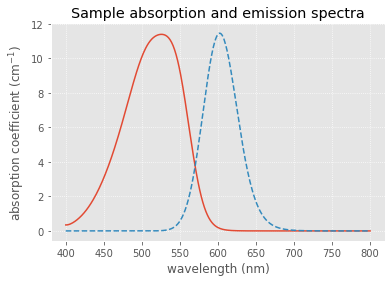

In [2]:
plt.style.use('ggplot')
x = np.arange(400, 801, dtype=np.float)
absorption_peak_per_cm = 11.387815
absorption_spectrum = fluro_red.absorption(x) * absorption_peak_per_cm
emission_spectrum = fluro_red.emission(x)
plt.plot(x, absorption_spectrum, label="absorption")
plt.plot(x, emission_spectrum * absorption_peak_per_cm, "--")
plt.grid(linestyle="dotted")
plt.xlabel("wavelength (nm)")
plt.ylabel("absorption coefficient (cm$^{-1}$)")
plt.title("Sample absorption and emission spectra")
plt.show()

# pvtrace script

> Thanks to [Jaydesh](https://github.com/jaydeshpande) for his contributions in completing this comparison.

The following script uses pvtrace to create an "LSC" object with the same properties as described above.

In [3]:
def create_waveguide():
    # Simulation wavelength range
    x = np.arange(400, 801, dtype=np.float)

    # LSC plate size
    size = (l, w, d) = (4.8, 1.8, 0.260)  # cm

    # Make LSC model
    lsc = LSC(size, wavelength_range=x, n1=1.5)
    # lsc.add_solar_cell({'left', 'right', 'near', 'far'})

    # Use Fluro Red dye with peak absorption coefficient 11.39 cm-1
    lsc.add_luminophore(
        "Fluro Red",
        np.column_stack((x, fluro_red.absorption(x) * 11.387815)),  # cm-1
        np.column_stack((x, fluro_red.emission(x))),
        quantum_yield=0.95,
    )

    # Include constant background absorption coefficient of 0.02 cm-1
    lsc.add_absorber("PMMA", 0.02)  # cm-1

    # This function returns an approximation of the lamp spectrum used in the experiment
    def lamp_spectrum(x):
        """ Fit to an experimentally measured lamp spectrum with long wavelength filter.
        """

        def g(x, a, p, w):
            return a * np.exp(-(((p - x) / w) ** 2))

        a1 = 0.53025700136646192
        p1 = 512.91400020614333
        w1 = 93.491838802960473
        a2 = 0.63578999789955015
        p2 = 577.63100003089369
        w2 = 66.031706473985736
        return g(x, a1, p1, w1) + g(x, a2, p2, w2)

    # Add a custon light
    lamp_dist = Distribution(x, lamp_spectrum(x))
    wavelength_callable = lambda: lamp_dist.sample(np.random.uniform())
    position_callable = lambda: rectangular_mask(l / 2, w / 2)
    lsc.add_light(
        "Oriel Lamp + Filter",
        (0.0, 0.0, 0.5 * d + 0.01),  # put close to top surface
        rotation=(np.radians(180), (1, 0, 0)),  # normal and into the top surface
        wavelength=wavelength_callable,  # wavelength delegate callable
        position=position_callable,  # uniform surface illumination
    )
    return lsc

**Recommended `num_runs` is 40**, this reduced uncertainty to around $\pm$1%.

However, on a single process this can take some time to complete. Until I modify this script to use multiple processing I will set this to 10, which completes the simulation in a few minutes.

In [4]:
num_rays = 1000
num_runs = 10
runs = {}
for i in range(num_runs):
    print("Run {}/{}".format(i+1, num_runs))
    lsc = create_waveguide()
    lsc.simulate(num_rays, emit_method="redshift")
    counts = lsc.counts()
    exit_ray_percentages = (
        100 * counts[["Solar Out", "Luminescent Out"]].sum(axis=1) / num_rays
    )
    runs[i] = exit_ray_percentages.to_list()

summary = pd.DataFrame.from_dict(runs, orient="index")
summary.rename(
    {0: "left", 1: "right", 2: "near", 3: "far", 4: "top", 5: "bottom"},
    axis=1,
    inplace=True,
)
summary

Run 1/10
Tracing finished.
Preparing results.
Run 2/10
Tracing finished.
Preparing results.
Run 3/10
Tracing finished.
Preparing results.
Run 4/10
Tracing finished.
Preparing results.
Run 5/10
Tracing finished.
Preparing results.
Run 6/10
Tracing finished.
Preparing results.
Run 7/10
Tracing finished.
Preparing results.
Run 8/10
Tracing finished.
Preparing results.
Run 9/10
Tracing finished.
Preparing results.
Run 10/10
Tracing finished.
Preparing results.


,left,right,near,far,top,bottom
0,5.0,5.3,6.8,6.4,13.2,51.1
1,5.0,5.3,9.0,6.7,13.5,50.0
2,6.2,4.8,7.3,6.0,15.2,48.8
3,5.5,6.0,7.6,6.4,14.3,49.6
4,5.5,7.0,7.1,7.5,14.1,47.3
5,5.8,6.4,6.5,7.7,14.1,47.5
6,6.6,5.0,5.3,6.1,15.1,49.3
7,4.9,5.1,5.9,8.3,14.6,47.7
8,4.6,7.4,7.1,7.6,12.6,48.3
9,6.7,5.7,7.6,7.9,11.7,48.3


Get idea of uncertainity in the simulations.

In [5]:
long_face = summary.near.values
short_face = summary.left.values
top_face = summary.top.values
bottom_face = summary.bottom.values

edge_summary = pd.Series(
    {
        "Near": "{:.1f}+-{:.1f}".format(np.mean(long_face), np.std(long_face)),
        "Left": "{:.1f}+-{:.1f}".format(np.mean(short_face), np.std(short_face)),
        "Top": "{:.1f}+-{:.1f}".format(np.mean(top_face), np.std(top_face)),
        "Bottom": "{:.1f}+-{:.1f}".format(np.mean(bottom_face), np.std(bottom_face)),
    }
)
pd.DataFrame(edge_summary, columns=["pvtrace"])

,pvtrace
Near,7.0+-1.0
Left,5.6+-0.7
Top,13.8+-1.0
Bottom,48.8+-1.2


The following data has been graphically extracted from Figure 3.21 in, 
> *Raytrace Simulations and Experimental Studies of Luminescent Solar Concentrators*, Rahul Bose, PhD Thesis (2014), https://core.ac.uk/download/pdf/76989828.pdf

In [6]:
df = pd.DataFrame(
[[49.227, 49.900, 49.739],
 [13.566, 13.807, 13.60],
 [7.287, 7.097, 7.166],
 [6.638, 5.768, 6.365]],
 index=["Bottom", "Top", "Near", "Left"],
 columns=["ICL Raytrace Model", "ICL 3D Flux Model", "ECN Raytrace Model"])
df.index.name = "Face"
df

,ICL Raytrace Model,ICL 3D Flux Model,ECN Raytrace Model
Face,,,
Bottom,49.227,49.900,49.739
Top,13.566,13.807,13.600
Near,7.287,7.097,7.166
Left,6.638,5.768,6.365


Include pvtrace results in the table

In [7]:
pvtrace_values = summary.mean()
df["pvtrace"] = np.nan
df["pvtrace"].Bottom = pvtrace_values.bottom
df["pvtrace"].Top = pvtrace_values.top
df["pvtrace"].Left = pvtrace_values.left
df["pvtrace"].Near = pvtrace_values.near
df

,ICL Raytrace Model,ICL 3D Flux Model,ECN Raytrace Model,pvtrace
Face,,,,
Bottom,49.227,49.900,49.739,48.79
Top,13.566,13.807,13.600,13.84
Near,7.287,7.097,7.166,7.02
Left,6.638,5.768,6.365,5.58


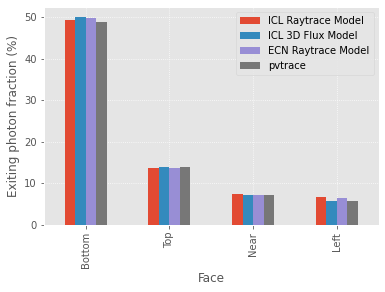

In [8]:
plt.style.use('ggplot')
df.plot.bar()
plt.grid(linestyle="dotted")
plt.ylabel("Exiting photon fraction (%)")
plt.show()

pvtrace has been validated against two other ray-tracers and a thermodyanmic model. 

(The above plot should be updated to include errors bars!)